# Introduction and Set Up

The first attempt at predicting house prices resulted in a high log MAE. Admittedly, there was minimal focus on feature engineering and more priority was placed on database cleaning.

In this notebook, I will attempt to systematically review the features using a mutual information method and determine if any features can be combined to create new features.

It should be noted that the algorithm that worked best in the previous attempt was Adoboost. This ML algorithm did, however, show evidence of overfitting the training dataset, and did not generalize well to the test data (as the MAE result showed). I am tempted to use the same algorithm again. But to avoid the risk of overfitting again, alternative algorithms will be considered such as Random Forest and SVR.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statistics as stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from pathlib import Path
import tarfile
import urllib.request

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_predict


In [2]:
#presentation and viewing preferences
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
sns.color_palette("hls", 10)
sns.set_palette("hls")

## Functions Used

In [3]:
#create mutual information (mi) functions
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [4]:
def score_dataset(X, y, model=RandomForestRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [5]:
def object_cleaner(df_objects):
    for col in df_objects:
        df_objects[col].fillna(df[col].value_counts().index[0], inplace = True)

In [6]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
def prepared_x(test):
    test.MSSubClass = test.MSSubClass.astype('object')
    test.OverallCond = test['OverallCond'].astype('int64')
    test.OverallQual = test['OverallQual'].astype('int64')
    test.MSZoning = test.MSZoning.astype('object')
    test.CentralAir = test.CentralAir.astype('object')
    
    #select features that will be clustered
    features = ['YearBuilt','OverallQual']
    
    X_scaled = test.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    
    kmeans = KMeans(n_clusters= 3, n_init= 7, random_state= 123)
    test["Cluster"] = kmeans.fit_predict(X_scaled)
    
    test.Cluster = test.Cluster.astype('category')
    
    #separate dataframe into numbers and objects/categories
    x_numbers = test.select_dtypes(include=['number'])
    x_objects = test.select_dtypes(exclude=['number'])
    
    #clean up messy data
    object_cleaner(x_objects) #clean up non-numeric features
    #transform non-numeric features into dummy variables
    dummy_objects = one_hot.transform(x_objects)
    
    #clean numeric features with imputer
    clean_x_numbers = imp.transform(x_numbers)
    
    #combine datasets
    prepared_x = np.concatenate([dummy_objects, clean_x_numbers], axis = 1)
    
    return prepared_x

## Explore the data

In [8]:
#load the training dataset

df = pd.read_csv("train.csv")

In [9]:
#explore the data
display(df.head(10))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [10]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = df.isnull().sum().sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print("The total % data missing in the dataframe: {0:.2f}%".format(percent_missing))

The total % data missing in the dataframe: 5.89%


In [12]:
#convert categorical features to category and objects
df.MSSubClass = df.MSSubClass.astype('object')
df.OverallCond = df['OverallCond'].astype('int64')
df.OverallQual = df['OverallQual'].astype('int64')
df.MSZoning = df.MSZoning.astype('object')
df.CentralAir = df.CentralAir.astype('object')

In [13]:
#separate dataframe into numbers and objects/categories
df_numbers = df.copy().select_dtypes(include=['number'])
df_objects = df.copy().select_dtypes(exclude=['number'])

In [14]:
df_objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   Alley          91 non-null     object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  RoofStyle      1460 non-null   object
 15  RoofMatl       1460 non-null   object
 16  Exterior1st    1460 non-null   object
 17  Exterior2nd    1460 non-null   object
 18  MasVnrType     1452 non-null

In [15]:
df_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [16]:
y = df_numbers.SalePrice
df_numbers.drop('SalePrice', inplace= True, axis = 1)

In [17]:
#iterative imputer to impute missing data
imp = IterativeImputer(imputation_order='ascending', 
                       max_iter=10, 
                       random_state=42, 
                       n_nearest_features=4)

imputed_df_nums = imp.fit_transform(df_numbers)

In [18]:
#impute missing data with either none for many missing values or the mode for few missing values
object_cleaner(df_objects)

In [19]:
df_objects.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,20,RL,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,60,RL,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,70,RL,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,60,RL,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [20]:
one_hot = OneHotEncoder(drop = 'first', sparse= False)
one_hot.fit(df_objects)
objects = one_hot.transform(df_objects)

In [21]:
print(objects.shape)
print(imputed_df_nums.shape)

(1460, 223)
(1460, 36)


In [22]:
prepared_df = np.concatenate([objects, imputed_df_nums], axis = 1)

In [23]:
prepared_df.shape

(1460, 259)

In [24]:
X = prepared_df

# Baseline analysis

A baseline analysis is necessary to review all features prior to feature engineering. 
A random forest will be used throughout this analysis.

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= 123, test_size= 0.20)

In [26]:
print("The shape of Xtrain is", Xtrain.shape)
print("The shape of Xtrain is", Xtest.shape)

The shape of Xtrain is (1168, 259)
The shape of Xtrain is (292, 259)


In [27]:
param_grid = [
    {"max_features":['auto','sqrt'],
    "n_estimators":[30, 50, 75, 100],
     "max_leaf_nodes": [None, 3, 6, 10]
    }] 

In [28]:
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid= param_grid, cv = 3, scoring= 'neg_mean_squared_error')
grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': ['auto', 'sqrt'],
                          'max_leaf_nodes': [None, 3, 6, 10],
                          'n_estimators': [30, 50, 75, 100]}],
             scoring='neg_mean_squared_error')

In [29]:
print("The best parameters: \n {} \n".format(grid_search.best_params_))
print("The best score: \n {} \n".format(np.sqrt(-grid_search.best_score_)))
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("{:.3f}".format(np.sqrt(-mean_score)), params)

The best parameters: 
 {'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 75} 

The best score: 
 33266.59816734583 

33857.312 {'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 30}
33529.246 {'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 50}
33266.598 {'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 75}
34031.279 {'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 100}
49476.514 {'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 30}
49761.881 {'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 50}
49648.641 {'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 75}
49156.606 {'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 100}
42563.340 {'max_features': 'auto', 'max_leaf_nodes': 6, 'n_estimators': 30}
42254.799 {'max_features': 'auto', 'max_leaf_nodes': 6, 'n_estimators': 50}
43090.410 {'max_features': 'auto', 'max_leaf_nodes': 6, 'n_estimators': 75}
42403.071 {'max_fe

In [30]:
#determine accuracy of best grid search estimators
best_forest = grid_search.best_estimator_

ypred_train = best_forest.predict(Xtrain)
ypred_test = best_forest.predict(Xtest)

#calculate the RMSE for test and train
best_MSE_train = mean_squared_error(ytrain, ypred_train)
best_MSE_test = mean_squared_error(ytest, ypred_test)

print("The RSME for the training set: \n {:.2f} ".format(np.sqrt(best_MSE_train)))
print("The RSME for the test set: \n {:.2f} ".format(np.sqrt(best_MSE_test)))

The RSME for the training set: 
 10964.26 
The RSME for the test set: 
 27517.61 


In [31]:
best_score_train = best_forest.score(Xtrain, ytrain)
best_score_test = best_forest.score(Xtest, ytest)

print("The accuracy for the training set: \n {:.4f} % ".format(best_score_train*100))
print("The accuracy for the test set: \n {:.4f} % ".format(best_score_test*100))

The accuracy for the training set: 
 98.1034 % 
The accuracy for the test set: 
 87.7465 % 


As shown above, the accuracy of the test set is significantly lower than the training set, indicating overfitting of the training set.

In [32]:
test = pd.read_csv("test.csv")

In [33]:
#convert variables to their correct dtypes
test.MSSubClass = test.MSSubClass.astype('object')
test.OverallCond = test['OverallCond'].astype('int64')
test.OverallQual = test['OverallQual'].astype('int64')
test.MSZoning = test.MSZoning.astype('object')
test.CentralAir = test.CentralAir.astype('object')

In [34]:
#separate dataframe into numbers and objects/categories
x_numbers = test.select_dtypes(include=['number'])
x_objects = test.select_dtypes(exclude=['number'])

In [35]:
x_objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1459 non-null   object
 1   MSZoning       1455 non-null   object
 2   Street         1459 non-null   object
 3   Alley          107 non-null    object
 4   LotShape       1459 non-null   object
 5   LandContour    1459 non-null   object
 6   Utilities      1457 non-null   object
 7   LotConfig      1459 non-null   object
 8   LandSlope      1459 non-null   object
 9   Neighborhood   1459 non-null   object
 10  Condition1     1459 non-null   object
 11  Condition2     1459 non-null   object
 12  BldgType       1459 non-null   object
 13  HouseStyle     1459 non-null   object
 14  RoofStyle      1459 non-null   object
 15  RoofMatl       1459 non-null   object
 16  Exterior1st    1458 non-null   object
 17  Exterior2nd    1458 non-null   object
 18  MasVnrType     1443 non-null

In [36]:
#convert MSSubClass of 150 to 160
x_objects.MSSubClass[x_objects.MSSubClass == 150] = 160

In [37]:
clean_x_objects = object_cleaner(x_objects)

In [38]:
#create dummy variables
dummy_objects = one_hot.transform(x_objects)

In [39]:
#clean numeric features with imputer
clean_x_numbers = imp.transform(x_numbers)

In [40]:
#combine datasets
prepped_x = np.concatenate([dummy_objects, clean_x_numbers], axis = 1)

In [41]:
prepped_x.shape

(1459, 259)

In [42]:
submissions = pd.DataFrame()

submissions['SalePrice'] = best_forest.predict(prepped_x)

In [43]:
submissions['Id'] = test.Id

In [44]:
submissions.set_index('Id', inplace= True)

In [45]:
submissions.to_csv('submission2 - base.csv')

## Feature Engineering

In [46]:
scores = make_mi_scores(df_objects, df.SalePrice)

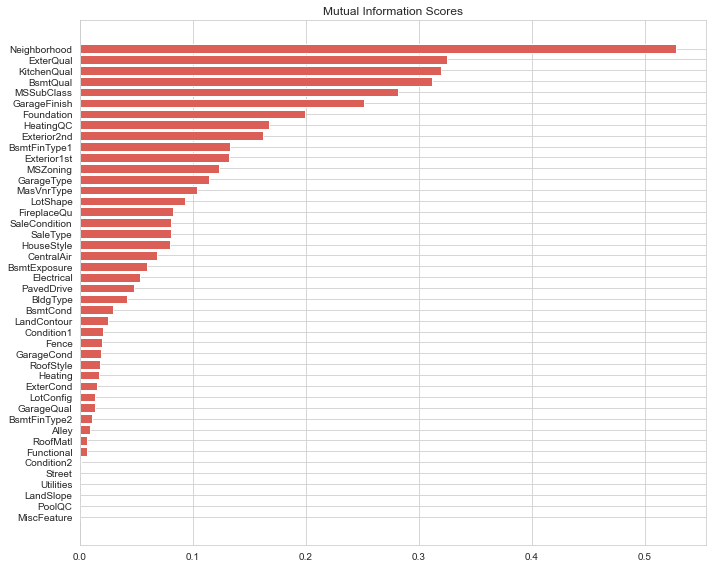

In [47]:
plt.figure(figsize=(10, 8))
plot_mi_scores(scores)
save_fig('Mutual Info Scores')

In [48]:
df.LandContour.value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

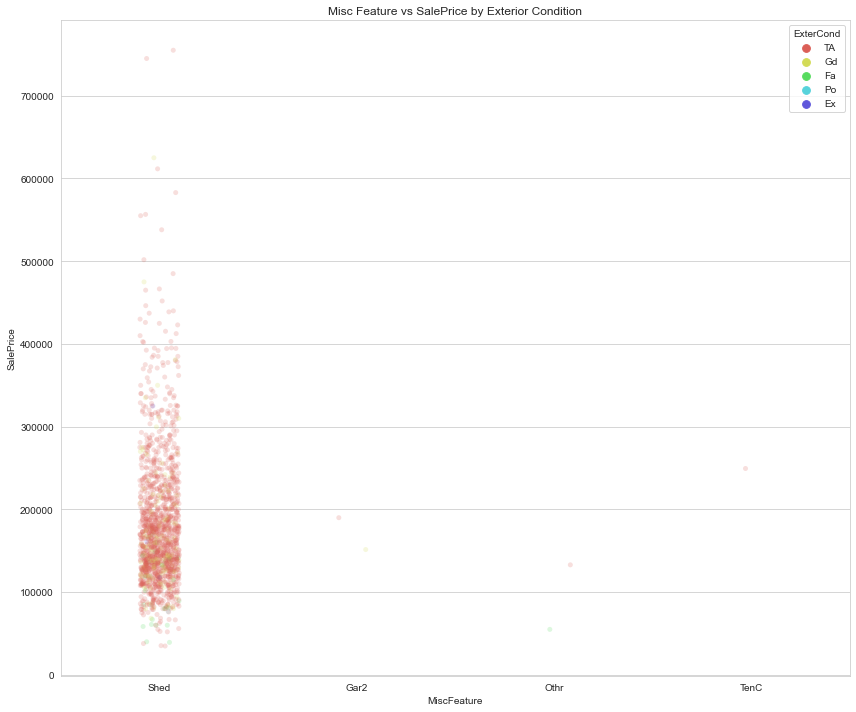

In [49]:
plt.figure(figsize=(12,10))
sns.stripplot(x = df_objects.MiscFeature, y = df.SalePrice, hue= df.ExterCond, alpha = 0.2)
plt.title('Misc Feature vs SalePrice by Exterior Condition')
save_fig('Stripplot - Misc Feature vs SalePrice by Exterior Condition')
plt.show()

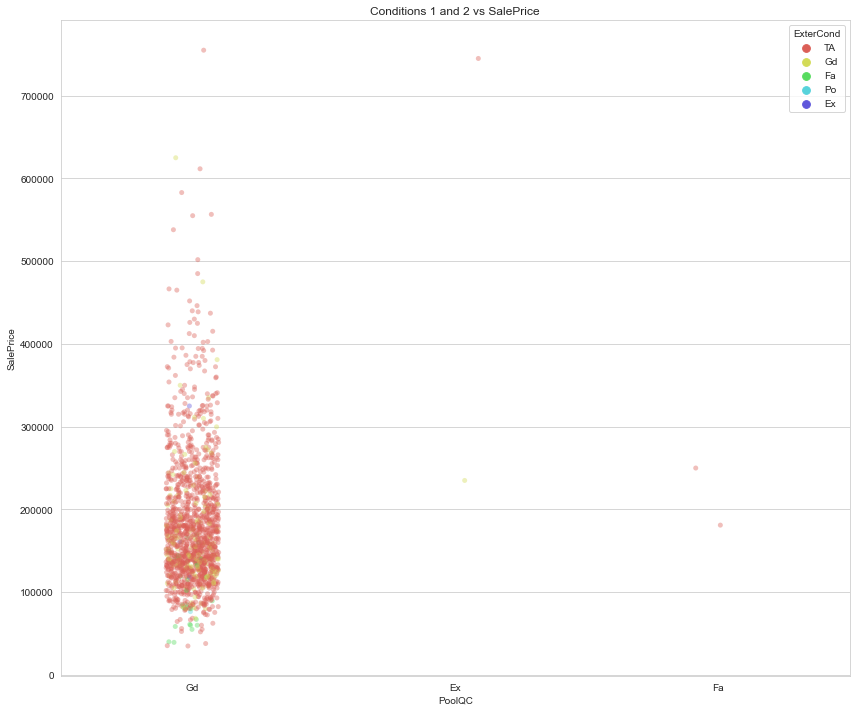

In [50]:
plt.figure(figsize=(12,10))
sns.stripplot(x = df_objects.PoolQC, y = df.SalePrice, hue= df.ExterCond, alpha = 0.4)
plt.title('Conditions 1 and 2 vs SalePrice')
save_fig('Stripplot - Conditions 1 and 2 vs SalePrice')
plt.show()

Features to drop
MiscFeatures = most features fall under "Shed". Shed appearances reduce significantly as the Sale Price increases
Conditions 1 and 2 = there is limited relationship to SalesPrice for both conditions.

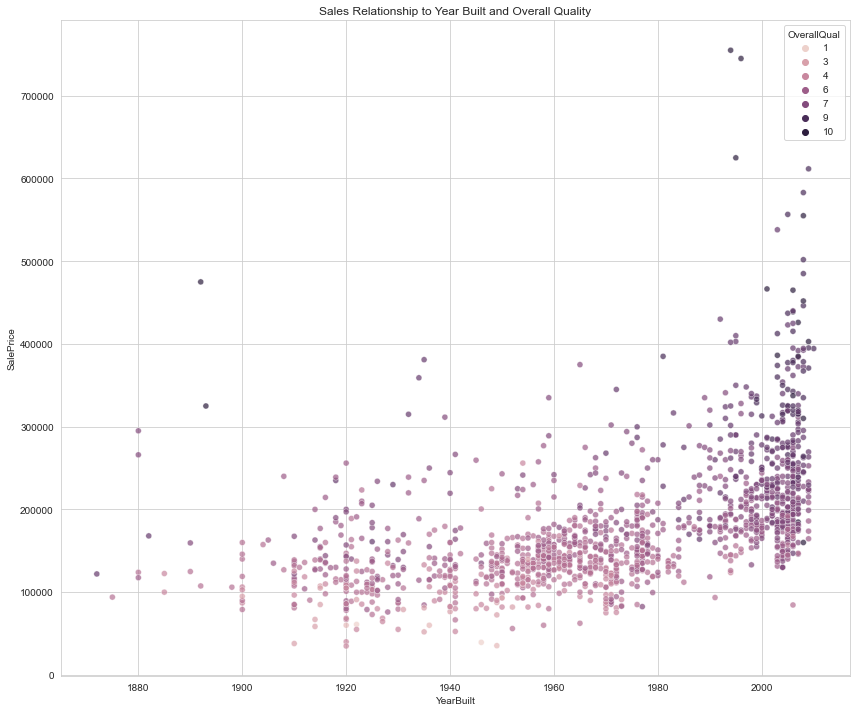

In [51]:
plt.figure(figsize=(12,10))
sns.scatterplot(x="YearBuilt", y = "SalePrice", hue = "OverallQual", data= df, alpha = 0.7)
plt.title("Sales Relationship to Year Built and Overall Quality")
save_fig("Sales Relationship to Year Built and Overall Quality")
plt.show()

There is a relationship between the YearBuilt, Overall Quality and Sale Price of a house. 
This can perhaps be summarised into a cluster - namely of YearBuilt and OverallQual to explain some variation in SalePrice

In [52]:
#select features that will be clustered
features = ['YearBuilt','OverallQual']

X_scaled = df.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters= 3, n_init= 7, random_state= 123)
df["Cluster"] = kmeans.fit_predict(X_scaled)

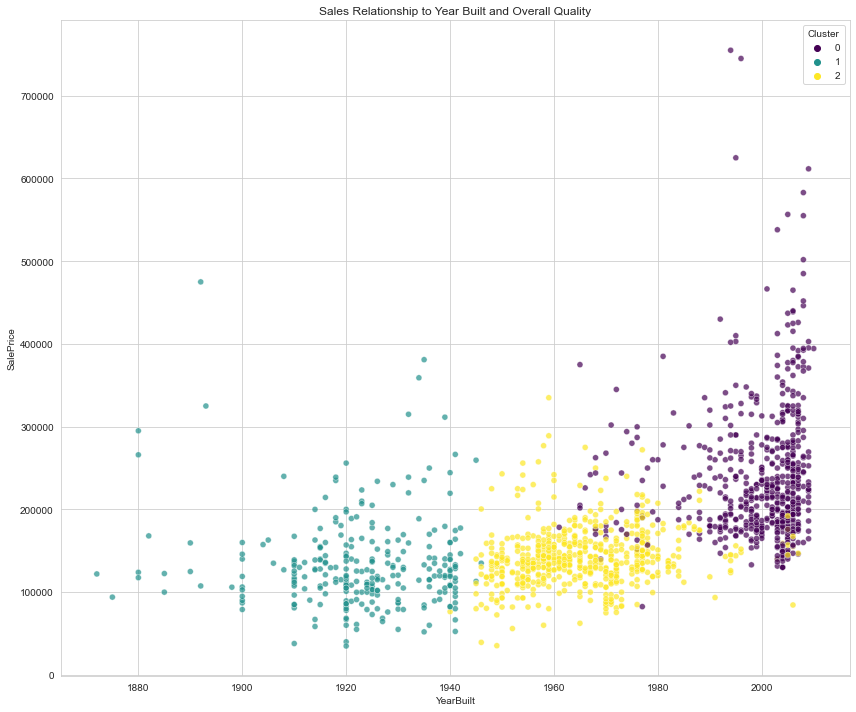

In [53]:
plt.figure(figsize=(12,10))
sns.scatterplot(x="YearBuilt", y = "SalePrice", hue = "Cluster", data= df, alpha = 0.7, palette="viridis")
plt.title("Sales Relationship to Year Built and Overall Quality")
save_fig("Sales Relationship to Year Built and Overall Quality")
plt.show()

The 3 cluster pairing does well to distinguish between three eras when looking at YearBuilt against the SalePrice. 

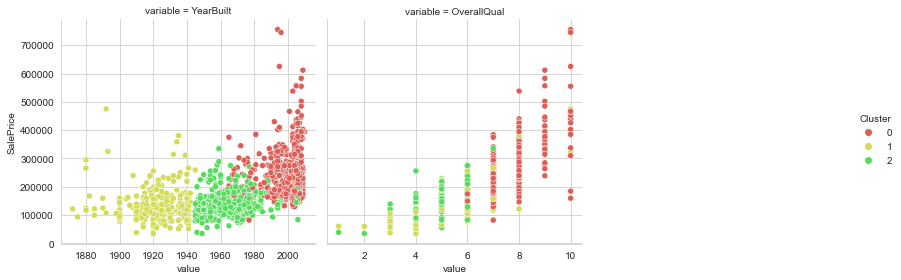

<Figure size 864x720 with 0 Axes>

In [54]:
Xy = df.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);
plt.figure(figsize= (12,10))
save_fig("Sale Price vs YearBuilt and OverallQual - 3 Cluster Grouping")
plt.show()

In [55]:
#prep_x_y(df)
df.MSSubClass = df.MSSubClass.astype('object')
df.OverallCond = df['OverallCond'].astype('int64')
df.OverallQual = df['OverallQual'].astype('int64')
df.MSZoning = df.MSZoning.astype('object')
df.CentralAir = df.CentralAir.astype('object')
df["Cluster"] = df.Cluster.astype("category")
    
#separate dataframe into numbers and objects/categories
df_nums = df.copy().select_dtypes(include=['number'])
df_objs = df.copy().select_dtypes(exclude=['number'])
    
#determine y
y = df_nums.SalePrice
df_nums.drop('SalePrice', inplace= True, axis = 1)   
    
    
#iterative imputer to impute missing data
imp = IterativeImputer(imputation_order='ascending', 
                       max_iter=10,
                       random_state=42, 
                       n_nearest_features=4)
imputed_df_nums = imp.fit_transform(df_numbers)
#clean object-type data
object_cleaner(df_objs)

#OnehotEncode objects
one_hot = OneHotEncoder(drop = 'first', sparse= False)
one_hot.fit(df_objs)
objs = one_hot.transform(df_objs)

prepared_df = np.concatenate([objs, imputed_df_nums], axis = 1)
X = prepared_df

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= 123, test_size= 0.20)

In [56]:
def predict_and_score(X, y, model = RandomForestRegressor(max_features= 'auto',
                                                          max_leaf_nodes= None)):
    score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_log_error")
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [57]:
predict_and_score(Xtrain, ytrain)

0.15422323751048028

In [58]:
predict_and_score(Xtest, ytest)

0.15243671397732678

In [65]:
print("Accuracy score of training set: {:.3f}%".format(forest.score(Xtrain, ytrain)*100))
print("Accuracy score of test set: {:.3f}%".format(forest.score(Xtest, ytest)*100))

Accuracy score of training set: 98.058%
Accuracy score of test set: 88.180%


Above results indicate overfitting. However, the test score remains fairly high.

In [59]:
prepped_xtest = prepared_x(test)

In [60]:
forest = RandomForestRegressor(max_features= 'auto', max_leaf_nodes= None)
forest.fit(Xtrain, ytrain)
test_pred = forest.predict(prepped_xtest)

In [61]:
#third submission after adding clusters
submissions = pd.DataFrame()

submissions['SalePrice'] = forest.predict(prepped_xtest)
submissions['Id'] = test.Id
submissions.set_index('Id', inplace= True)
submissions.to_csv('submission3 - YrsQualCluster.csv')